<a href="https://colab.research.google.com/github/boufik/Google-Colab-Projects/blob/main/Deal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rules

This Deal version has 22 cases in total.
* In the 1st round, the player opens 5 cases, so round1_offer is based on the 17 remaining values.
* In the 2nd round, the player opens 3 cases, so round2_offer is based on the 14 remaining values.
* In the 3rd round, the player opens 3 cases, so round3_offer is based on the 11 remaining values.
* In the 4th round, the player opens 3 cases, so round4_offer is based on the 8 remaining values.
* In the 5th round, the player opens 3 cases, so round5_offer is based on the 5 remaining values.
* In the 6th round, the player opens 2 cases, so round6_offer is based on the 3 remaining values.
* In the 7th round, the player opens 1 case, so round7_offer is based on the 2 remaining values.

# Auxiliary Functions

## 1. Transform Function

In [48]:
def transform_original(df):
    """
    Input: original dataframe with default features
    Output: transformed dataframe with engineered features
    """
    # Clean the column 'Offer' --> Remove € and commas if present --> Make it a numeric column
    df["Offer"] = (df["Offer"].astype(str).str.replace("€", "", regex=False).str.replace(",", "", regex=False).str.strip())
    df["Offer"] = pd.to_numeric(df["Offer"], errors="coerce")
    # Identify amount columns (everything except metadata)
    metadata_cols = ["Offer", "Date", "Timestamp"]
    amount_cols = [cname for cname in df.columns if cname not in metadata_cols]
    # Row-by-row Transformation
    transformed_rows = []
    for idx, row in df.iterrows():
        remaining_values = []
        for cname in amount_cols:
            if row[cname] == 1:
                try:
                    remaining_values.append(float(cname))
                except:
                    pass
        cases_left = len(remaining_values)
        if cases_left == 0:
            continue
        # 1) Engineered Features (first 5)
        EV = np.mean(remaining_values)
        std_remaining = np.std(remaining_values)
        max_value = np.max(remaining_values)
        min_value = np.min(remaining_values)
        if cases_left >= 3:
            top3_sum = sum(sorted(remaining_values, reverse=True)[:3])
        else:
            top3_sum = sum(remaining_values)
        transformed_row = {"EV": EV, "std": std_remaining, "max_value": max_value, "min_value": min_value, "top3_sum": top3_sum}
        # 2) Engineered Features (last 3)
        transformed_row["cases_left"] = cases_left
        match cases_left:
            case 17:
                transformed_row["cases_to_open_next"] = 3
                transformed_row["round"] = 1
            case 14:
                transformed_row["cases_to_open_next"] = 3
                transformed_row["round"] = 2
            case 11:
                transformed_row["cases_to_open_next"] = 3
                transformed_row["round"] = 3
            case 8:
                transformed_row["cases_to_open_next"] = 3
                transformed_row["round"] = 4
            case 5:
                transformed_row["cases_to_open_next"] = 2
                transformed_row["round"] = 5
            case 3:
                transformed_row["cases_to_open_next"] = 1
                transformed_row["round"] = 6
            case 2:
                transformed_row["cases_to_open_next"] = 0
                transformed_row["round"] = 7
        # 3) Target Columns: Offer + k
        transformed_row["Offer"] = row["Offer"]
        transformed_row["k"] = row["Offer"] / EV
        # 4) Metadata Features
        if "Date" in df.columns:
            transformed_row["Date"] = row["Date"]
        # Append the row
        transformed_rows.append(transformed_row)
    df_transformed = pd.DataFrame(transformed_rows)
    return df_transformed

## 2. Plotting Functions

In [49]:
def plot_separate_dates(df_transformed):
    """
    This function creates one separate lineplot per 'Date'
    """
    # Sort the dataframe to ensure correct ordering
    df_transformed = df_transformed.sort_values(["Date", "round"])
    unique_dates = df_transformed["Date"].unique()
    for date in unique_dates:
        # Filtering
        subset = df_transformed[df_transformed["Date"] == date]
        # In case multiple entries/rows per round exist
        grouped = subset.groupby("round", as_index=False)["k"].mean()
        plt.figure()
        plt.plot(grouped["round"], grouped["k"])
        plt.xlabel("Round")
        plt.ylabel("k = Offer / EV")
        plt.title(f"{date}: The k Trend by Round")
        plt.show()


def plot_all_dates(df_transformed):
    """
    This function creates one combined plot with all dates
    """
    # Sort the dataframe to ensure correct ordering
    df_transformed = df_transformed.sort_values(["Date", "round"])
    unique_dates = df_transformed["Date"].unique()
    plt.figure()
    for date in unique_dates:
        # Filtering
        subset = df_transformed[df_transformed["Date"] == date]
        # In case multiple entries/rows per round exist
        grouped = subset.groupby("round", as_index=False)["k"].mean()
        plt.plot(grouped["round"], grouped["k"], label=str(date))
    plt.xlabel("Round")
    plt.ylabel("k = Offer / EV")
    plt.title("All Dates: The k Trend by Round")
    plt.legend()
    plt.show()

## 3. Average Function

In [50]:
def calculate_average_k_per_round(df_transformed):
  unique_rounds = df_transformed["round"].unique()
  avg_ks = list()
  for round in unique_rounds:
    # Filtering
    subset = df_transformed[df_transformed["round"] == round]
    avg_k = subset["k"].mean()
    avg_ks.append(avg_k)
    print(f"Round {round}: avg_k = {100 * avg_k:2}%")
  return avg_ks

## 4. Print average k in bar plot

In [51]:
def plot_average_k_per_round(avg_ks):
    unique_rounds = list(range(1, len(avg_ks) + 1))
    plt.figure()
    bars = plt.bar(unique_rounds, avg_ks, color="#a8dae8")
    plt.xlabel("Round")
    plt.ylabel("Average k")
    plt.title("Average k = Offer / EV per Round")
    # Add centered value labels inside each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{100*height:.2f}%", ha="center", va="center")
    plt.tight_layout()
    plt.show()

# MAIN FUNCTION

## 1. Tranform the original DataFrame

In [52]:
filepath = "/content/Deal.xlsx"
df = pd.read_excel(filepath)
df_transformed = transform_original(df)
df_transformed.head(7)

,EV,std,max_value,min_value,top3_sum,cases_left,cases_to_open_next,round,Offer,k,Date
0,5036.824118,9950.176687,40000.0,0.01,67500.0,17,3,1,300.0,0.059561,2026-02-27
1,5562.571429,10773.254295,40000.0,1.00,65000.0,14,3,2,900.0,0.161796,2026-02-27
2,6623.181818,11872.583443,40000.0,5.00,64000.0,11,3,3,2000.0,0.301970,2026-02-27
3,1544.375000,1310.618741,4000.0,5.00,9000.0,8,3,4,600.0,0.388507,2026-02-27
4,1351.000000,1042.738702,3000.0,5.00,6000.0,5,2,5,800.0,0.592154,2026-02-27
5,1335.000000,1245.438343,3000.0,5.00,4005.0,3,1,6,1000.0,0.749064,2026-02-27
6,2000.000000,1000.000000,3000.0,1000.00,4000.0,2,0,7,1800.0,0.900000,2026-02-27


## 2. Visualize the 'k' trend

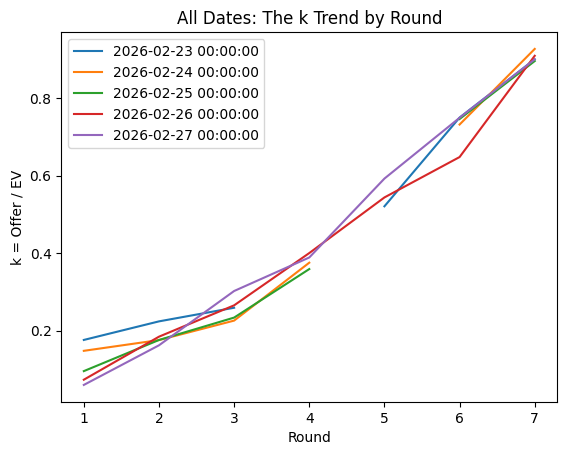

In [53]:
plot_all_dates(df_transformed)

## 3. Calculate the average 'k' value per round

Round 1: avg_k = 11.019925851633658%
Round 2: avg_k = 18.40635349836995%
Round 3: avg_k = 25.694294657209326%
Round 4: avg_k = 38.0521071127564%
Round 5: avg_k = 55.20755509119378%
Round 6: avg_k = 72.47898220136632%
Round 7: avg_k = 90.62884230887036%




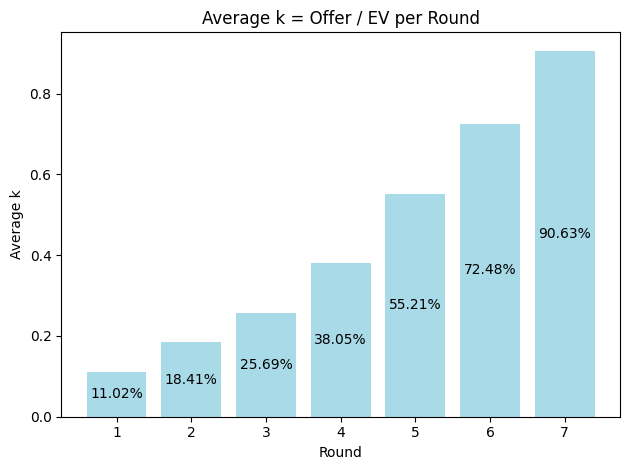

In [54]:
avg_ks = calculate_average_k_per_round(df_transformed)
print("\n")
plot_average_k_per_round(avg_ks)